In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Model definition

In [2]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # Output mean and log-variance
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output values between 0 and 1
        )
        
    def reparameterize(self, mu, log_var):
        """Reparameterization trick to sample from the latent space."""
        # std = torch.exp(0.5 * log_var.clamp(min=-10, max=10))
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std, device=device)
        return mu + eps * std
    
    def forward(self, x):
        # Encode
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=-1)  # Split into mean and log-variance
        
        # Reparameterize
        z = self.reparameterize(mu, log_var)
        
        # Decode
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed, mu, log_var

In [3]:
def vae_loss(reconstructed_x, x, mu, log_var):
    # Reconstruction loss (binary cross-entropy for binary data)
    reconstruction_loss = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    
    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # Total loss
    return reconstruction_loss + kl_divergence

## Data processing

In [4]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

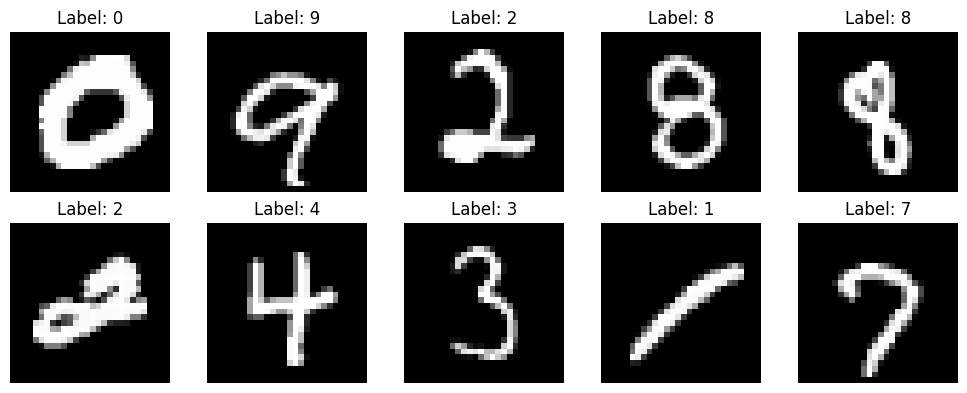

In [5]:
def show_images(images, labels, nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimensions
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of data from the DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)  # Get the first batch

# Reshape images back to 28x28 (they were flattened during transformation)
images = images.view(-1, 28, 28)  # Reshape from (batch_size, 784) to (batch_size, 28, 28)

# Display some images
show_images(images, labels, nrows=2, ncols=5)

## Model training

In [6]:
# Hyperparameters
input_dim = 784  # 28x28 flattened MNIST images
hidden_dim = 512
latent_dim = 64
learning_rate = 1e-3
num_epochs = 10



# Initialize model, optimizer, and loss function
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data.to(device)
        
        # Forward pass
        reconstructed_x, mu, log_var = model(data)
        
        # Compute loss
        loss = vae_loss(reconstructed_x, data, mu, log_var)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss / len(train_loader.dataset):.4f}")

Epoch [1/10], Loss: 166.0419
Epoch [2/10], Loss: 125.3065
Epoch [3/10], Loss: 116.1413
Epoch [4/10], Loss: 112.2437
Epoch [5/10], Loss: 110.0438
Epoch [6/10], Loss: 108.6393
Epoch [7/10], Loss: 107.5887
Epoch [8/10], Loss: 106.8271
Epoch [9/10], Loss: 106.2922
Epoch [10/10], Loss: 105.8109


## Generating similar datapoints

tensor([[-1.0979e-01,  7.9492e-02, -4.4931e-02, -3.9449e-02, -3.7760e-01,
          2.5867e-02,  7.9217e-02, -7.5622e-02, -1.0674e-01, -3.8294e-01,
         -3.0065e-01, -2.3011e-01, -9.8805e-02,  4.5376e-02, -1.2473e-01,
         -8.7550e-02,  7.6531e-02, -9.3382e-02, -5.8867e-02,  1.3406e-02,
          1.8705e-01, -4.6824e-02,  1.6937e-01, -1.7256e-01, -2.3525e-01,
         -2.1259e-01,  1.8096e-01,  6.8918e-03,  1.7796e-01, -1.2976e-01,
         -3.8126e-01,  3.2459e-01,  5.3626e-01, -2.4262e-01,  7.8749e-02,
          8.1344e-02, -5.5925e-02, -3.3375e-01,  3.9642e-02,  1.4163e-01,
          2.2624e-03, -2.3133e-01, -9.7423e-02, -7.8045e-02, -3.2282e-03,
         -2.9865e-02,  3.0515e-01,  1.2206e-01,  2.5564e-01, -3.7954e-01,
          9.9376e-02, -1.7182e-01,  1.2727e-01, -9.1129e-02, -8.1882e-02,
          6.9643e-02,  1.8772e-01, -1.1465e-01,  2.1377e-01, -4.4313e-02,
          3.4945e-01, -2.8833e-01, -2.2527e-02,  5.8205e-01],
        [ 1.0123e-01,  8.3088e-02, -1.5993e-02, -3

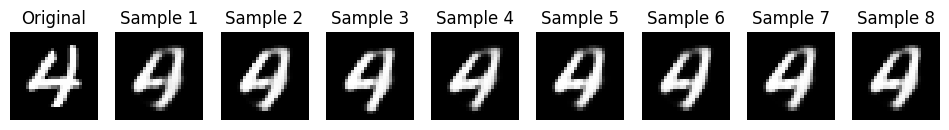

In [7]:
# Assume x is a batch of input images (flattened)
x, _ = next(iter(train_loader))  # Get a batch of data
x = x[:1]  # Take the first image in the batch

# Encode the input
model.eval()
with torch.no_grad():
    h = model.encoder(x.to(device))
    mu, log_var = torch.chunk(h, 2, dim=-1)
    z = model.reparameterize(mu, log_var)

    # Generate similar samples by adding noise
    noise = (torch.randn(8, latent_dim) * 0.2).to(device)  # 8 samples with small noise
    # noise = torch.zeros(8, latent_dim).to(device) # no noise


    print(noise)
    z_modified = z + noise

    # Decode the modified latent vectors
    generated_images = model.decoder(z_modified)

    # Reshape and plot
    generated_images = generated_images.view(-1, 28, 28).cpu()
    original_image = x.view(28, 28).cpu()

    fig, axes = plt.subplots(1, 9, figsize=(12, 2))  # 1 original + 8 generated
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis('off')

    for i, ax in enumerate(axes[1:]):  # Plot generated images
        ax.imshow(generated_images[i], cmap='gray')
        ax.set_title(f"Sample {i+1}")
        ax.axis('off')

    plt.show()

In [ ]:
torch.cuda.empty_cache()

## Random generation

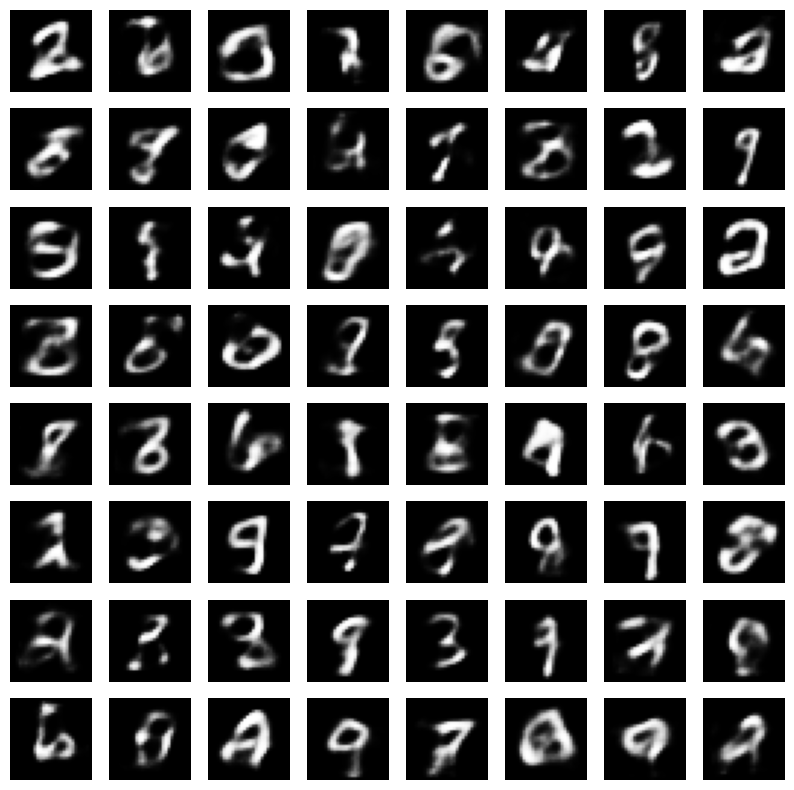

In [6]:
# Generate new samples
model.eval()
with torch.no_grad():
    # Sample from the latent space
    z = torch.randn(64, latent_dim)  # 64 samples
    generated_images = model.decoder(z)
    
    # Reshape and plot
    generated_images = generated_images.view(-1, 28, 28).cpu()
    fig, axes = plt.subplots(8, 8, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(generated_images[i], cmap='gray')
        ax.axis('off')
    plt.show()